<a href="https://colab.research.google.com/github/namita0210/Text-Sentiment-Classifier/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from kagglehub import dataset_download
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
import numpy as np
from scipy.sparse import hstack
import string
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as lemmy
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Embedding, Dense, Flatten
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng') # It uses the perceptron algorithm to assign parts of speech to words based on context.
nltk.download('punkt') # for tokenizing text to words or sentences
nltk.download('stopwords') # populary removed words
nltk.download('wordnet') #dictionary of words to reduce them to their base form : lemmatize
nltk.download('averaged_perceptron_tagger')  # For POS tagging
from sklearn.linear_model import LogisticRegression
print("Done")

C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_dat

Done


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Download latest version
path = dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\nnn866470\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


In [3]:
train_df = pd.read_csv(path + '/twitter_training.csv' , header = None)
val_df = pd.read_csv(path + '/twitter_validation.csv', header = None)
train_df.columns = ['id','title','sentiment','text']
val_df.columns = ['id','title','sentiment','text']

print(f'''Train Df Shape : {train_df.shape}
Validation Df Shape : {val_df.shape}''')

Train Df Shape : (74682, 4)
Validation Df Shape : (1000, 4)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   title      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
train_df.dropna(subset=['text'], inplace=True)

In [6]:
train_df.head(2)

,id,title,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...


In [7]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1000 non-null   int64 
 1   title      1000 non-null   object
 2   sentiment  1000 non-null   object
 3   text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [8]:
val_df.head(2)

,id,title,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


In [9]:
train_df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [10]:
train_df['sentiment'].value_counts()

sentiment
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

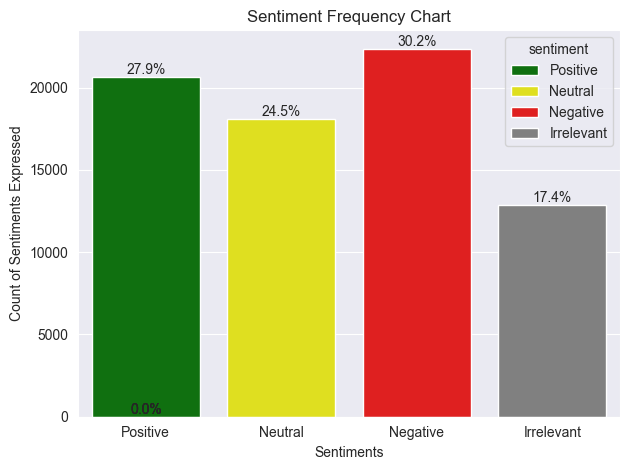

In [12]:
color = {'Positive':'Green', 'Neutral':'Yellow', 'Irrelevant':'Grey','Negative':'Red'}

total = len(train_df['sentiment'])
ax = sns.countplot(x='sentiment', data = train_df,order=['Positive','Neutral','Negative','Irrelevant']
              ,hue='sentiment'
              ,legend=True
              ,palette=color) #The function returns a matplotlib.axes.Axes object (which is essentially the plotting area), and we store it in the variable ax. This ax object allows us to further customize the plot, like adding annotations.

for p in ax.patches: #ax.patches is a list-like object that contains all the rectangular patches (the bars) that make up the countplot.
    percentage = '{:.1f}%'.format(100 * p.get_height()/total) #p.get_height(): This method returns the height of the current bar. In a countplot, the height of a bar represents the count of observations for that category.
    x = p.get_x() + p.get_width() / 2 # To tell at which coordinate to place the percentage

    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.xlabel('Sentiments')
plt.ylabel('Count of Sentiments Expressed')
plt.title('Sentiment Frequency Chart')
plt.tight_layout()
plt.show()

### Clean the Data

In [11]:
stop_words = set(stopwords.words('english')) #stopwords is a class whose object is words and english is it's argument which is stored in a variable called stop_words

lm = lemmy() #lm is an instance of the lemmy() class

In [12]:
def clean(text):
    text=text.lower() #lowercase

    no_punct = re.sub(r'[^a-z\s]','',text) #remove punctuation, digits

    words = word_tokenize(no_punct) #split text into words, returns a list

    words = [i for i in words if i not in stop_words] #remove stopwords

    pos_tags = nltk.pos_tag(words) # returns a tuple (word, pos tag)

    words = [
    lm.lemmatize(word, pos='v') if tag.startswith('V') else  # If tag starts with 'V', treat as verb
    lm.lemmatize(word, pos='n') if tag.startswith('N') else  # If tag starts with 'N', treat as noun
    lm.lemmatize(word, pos='a') if tag.startswith('R') else  # If tag starts with 'R', treat as adjective/adverb
    lm.lemmatize(word)  # Default to noun if no match
    for word, tag in pos_tags
    ] #returns list of string ['cat', 'be', 'run', 'quickly']

    clean_words = ' '.join(words) # joins the words in a string separated by a space "cat be run quickly"

    return clean_words #This is a string

In [13]:
train_df['text']=train_df['text'].apply(clean)

In [14]:
train_df.head()

,id,title,sentiment,text
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland murder


In [15]:
train_df['text']=train_df['text'].apply(word_tokenize) #Because we need a list of words to create vocabulary for bow

In [16]:
train_df.head(3)

,id,title,sentiment,text
0,2401,Borderlands,Positive,"[im, get, borderland, murder]"
1,2401,Borderlands,Positive,"[come, border, kill]"
2,2401,Borderlands,Positive,"[im, get, borderland, kill]"


### BOW

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

In [18]:
# Step 1: Get the data and ensure proper tokenization
train_df = train_df.sample(frac=1) #shufflic 100% of the data
bow_test = val_df.head(10)
bow_data = train_df.head(20)

In [21]:
bow_data['sentiment'].unique()

array(['Irrelevant', 'Negative', 'Positive', 'Neutral'], dtype=object)

In [22]:
bow_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 33161 to 2940
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20 non-null     int64 
 1   title      20 non-null     object
 2   sentiment  20 non-null     object
 3   text       20 non-null     object
dtypes: int64(1), object(3)
memory usage: 800.0+ bytes


In [23]:
# Step 2 - Create a vocabulary
my_series = bow_data['text'].explode()
print(type(my_series))
my_np_array = my_series.unique()
print(type(my_np_array))
my_np_array=my_np_array.astype(str)
print(type(my_np_array))
sorted_array = sorted(my_np_array)
corpus = sorted_array

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [24]:
print(len(corpus))

170


In [25]:
# Step 3 - Vectorization
# Join tokens back into strings (required by CountVectorizer)
bow_data.loc[:, 'text_joined'] = bow_data['text'].str.join(' ')
vectorizer = CountVectorizer(vocabulary=corpus)
X_bow = vectorizer.fit_transform(bow_data['text_joined'])

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_17000\3876171451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_data.loc[:, 'text_joined'] = bow_data['text'].str.join(' ')


In [26]:
X_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 181 stored elements and shape (20, 170)>

In [27]:
# Step 3.1 - Combine the bow matrix with the other features in the dataframe
print(f'''{bow_data['title'].unique()}
{bow_data['sentiment'].unique()}''')

categorical_feature_0 = pd.get_dummies(bow_data['title']).values

['Fortnite' 'HomeDepot' 'Cyberpunk2077' 'CallOfDuty' 'NBA2K' 'Dota2'
 'TomClancysGhostRecon' 'PlayStation5(PS5)' 'Facebook' 'Hearthstone'
 'MaddenNFL' 'PlayerUnknownsBattlegrounds(PUBG)'
 'CallOfDutyBlackopsColdWar']
['Irrelevant' 'Negative' 'Positive' 'Neutral']


In [39]:
X_bow_combo = hstack([categorical_feature_0, X_bow])
print(type(X_bow_combo))

<class 'scipy.sparse._coo.coo_matrix'>


In [29]:
model = LogisticRegression( class_weight='balanced',max_iter=1000)
model.fit(X_bow_combo, bow_data['sentiment'])


LogisticRegression(max_iter=1000)

In [45]:
print(type(bow_test['text']))
bow_test

<class 'pandas.core.series.Series'>


,id,title,sentiment,text
0,3364,Facebook,Irrelevant,"[I, mentioned, on, Facebook, that, I, was, str..."
1,352,Amazon,Neutral,"[BBC, News, -, Amazon, boss, Jeff, Bezos, reje..."
2,8312,Microsoft,Negative,"[@, Microsoft, Why, do, I, pay, for, WORD, whe..."
3,4371,CS-GO,Negative,"[CSGO, matchmaking, is, so, full, of, closet, ..."
4,4433,Google,Neutral,"[Now, the, President, is, slapping, Americans,..."
5,6273,FIFA,Negative,"[Hi, @, EAHelp, I, ’, ve, had, Madeleine, McCa..."
6,7925,MaddenNFL,Positive,"[Thank, you, @, EAMaddenNFL, !, !, New, TE, Au..."
7,11332,TomClancysRainbowSix,Positive,"[Rocket, League, ,, Sea, of, Thieves, or, Rain..."
8,1107,AssassinsCreed,Positive,"[my, ass, still, knee-deep, in, Assassins, Cre..."
9,2069,CallOfDuty,Negative,"[FIX, IT, JESUS, !, Please, FIX, IT, !, What, ..."


In [46]:
bow_test['text']=bow_test['text'].apply(clean)

AttributeError: 'list' object has no attribute 'lower'

In [38]:
corpus = bow_test['text'].explode().unique().astype(str)
corpus = sorted(corpus)

In [32]:
y_pred = model.predict(bow_test)

C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Facebook'

### TF - IDF

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
X = vectorizer.fit_transform(train_df['text'])

In [ ]:
X

In [ ]:
type(X)

In [ ]:
print(X)

Most of the elements in a TF-IDF matrix are typically zero (because most words don't appear in most documents).  Storing all those zeros would be extremely inefficient.  Sparse matrix formats like COO, Compressed Sparse Row (CSR), and Compressed Sparse Column (CSC) only store the non-zero values and their indices, saving a huge amount of memory.

In [ ]:
tf_idf_matrix = X

In [ ]:
sentiment_map = {
    'Positive': 3,
    'Neutral': 1,
    'Irrelevant': 2,
    'Negative': 0
}

In [ ]:
train_df['sentiment'] = train_df['sentiment'].map(sentiment_map)

In [ ]:
len(train_df['title'].unique())

In [ ]:
le = LabelEncoder()
train_df['title'] = le.fit_transform(train_df['title'])

In [ ]:
train_df.head(2)

In [ ]:
target = train_df['sentiment']

In [ ]:
independent_variables = ['id','title']
features = train_df[independent_variables].values

In [ ]:
features.values

In [ ]:
print(f'''dimension = {features.values.ndim}
shape = {features.values.shape}''')

In [ ]:
print(f'''dimension = {tf_idf_matrix.ndim}
shape = {tf_idf_matrix.shape}''')

In [ ]:
features = hstack((features,tf_idf_matrix))

In [ ]:
features

#Training a neural network to predict the sentiment based on the independent variables in my dataframe.

In [ ]:
num_categories = features.shape[1]
print(num_categories)

In [ ]:
embedding_dim = 5

In [ ]:
nn = Sequential()

In [ ]:
nn.add(Embedding(input_dim=num_categories,  # 32 categories
                    output_dim=embedding_dim,  # Dimension of the embedding vector (e.g., 5)
                    input_length=1))

In [ ]:
nn.add(Flatten())

In [ ]:
nn.add(Dense(64, activation='relu'))  # Hidden layer with 64 neurons
nn.add(Dense(32, activation='relu'))

In [ ]:
nn.add(Dense(4, activation='softmax'))  # Output layer with 4 classes (0-3)

In [ ]:
# Compile the model
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
nn.summary()

In [ ]:
nn.fit(features, target, epochs=10, batch_size=32)

In [ ]:
import numpy as np

A = np.random.randn(3,4)
B = np.random.randn(4,3)

print(f''' A : {type(A)}
      B:  {type(B)}
      A multiplied by B : {A@B}''')